In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split

In [45]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')
test = pd.merge(test, gender_submission, on='PassengerId')
print(train.columns)
print(test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'Fare',
       'Embarked_Cherbourg', 'Embarked_Queenstown', 'Embarked_Southampton',
       'Alone', 'Large', 'Medium', 'Small', 'Female', 'Male'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Age', 'Fare', 'Embarked_Cherbourg',
       'Embarked_Queenstown', 'Embarked_Southampton', 'Alone', 'Large',
       'Medium', 'Small', 'Female', 'Male', 'Survived'],
      dtype='object')


In [48]:
X_train = train[['PassengerId', 'Survived', 'Pclass', 'Age', 'Fare',
       'Embarked_Cherbourg', 'Embarked_Queenstown', 'Embarked_Southampton',
       'Alone', 'Large', 'Medium', 'Small', 'Female', 'Male']]
y_train = train['Survived']

In [49]:
X_test = test[['PassengerId', 'Survived', 'Pclass', 'Age', 'Fare',
       'Embarked_Cherbourg', 'Embarked_Queenstown', 'Embarked_Southampton',
       'Alone', 'Large', 'Medium', 'Small', 'Female', 'Male']]
y_test = test['Survived']

# Random Forest

In [51]:
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8, 16],
}

# Crear el modelo de GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [53]:
# Predecir los datos de prueba usando el mejor modelo encontrado por GridSearchCV
y_pred_rf = grid_search.best_estimator_.predict(X_test)

# test['random forest prediction'] = y_pred_rf
# test['Survived'] = y_test['Survived']

Accuracy: 1.00000000
Precision: 1.00000000
Confusion Matrix:
[[265   0]
 [  0 152]]


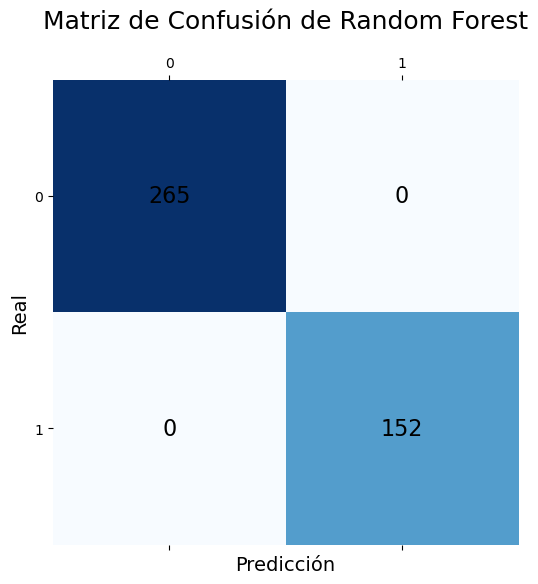

In [72]:
# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy:.8f}')

# Evaluar la precision
precision = precision_score(y_test, y_pred_rf)
print(f'Precision: {precision:.8f}')

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix:')
print(conf_matrix)
# Graficar la matriz de confusión con matshow
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)  # Utilizar fignum=1 para evitar la creación de una nueva figura
plt.title('Matriz de Confusión de Random Forest', pad=20, fontsize=18)
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Real', fontsize=14)

# Agregar las anotaciones de los valores en la matriz
for (i, j), val in np.ndenumerate(conf_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', fontsize=16, color="black")

# Remover la barra de color
plt.gca().set_frame_on(False)  # Remueve el borde alrededor de la matriz

plt.show()

# Red neuronal feed forward

In [58]:
# Definir una función para construir y compilar el modelo
def create_model(dropout_rate=0.0, learning_rate=0.001, optimizer='adam'):
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Definir los hiperparámetros a explorar
param_grid = {
    'dropout_rate': [0.0, 0.2],
    'learning_rate': [0.001, 0.01],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [20, 50],
    'epochs': [50, 100]
}

# Realizar la búsqueda manual de hiperparámetros
best_score = -np.inf
best_params = {}

for dropout_rate in param_grid['dropout_rate']:
    for learning_rate in param_grid['learning_rate']:
        for optimizer in param_grid['optimizer']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    model = create_model(dropout_rate=dropout_rate,
                                         learning_rate=learning_rate,
                                         optimizer=optimizer)
                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                    score = model.evaluate(X_test, y_test, verbose=0)[1]  # [1] es para la precisión

                    if score > best_score:
                        best_score = score
                        best_params = {
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'optimizer': optimizer,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }

print(f"Mejor precisión: {best_score}")
print(f"Mejores hiperparámetros: {best_params}")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Mejor precisión: 1.0
Mejores hiperparámetros: {'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 50, 'epochs': 100}


In [59]:
# Entrenar el mejor modelo encontrado
best_model = create_model(dropout_rate=best_params['dropout_rate'],
                          learning_rate=best_params['learning_rate'],
                          optimizer=best_params['optimizer'])

best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)



Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5874 - loss: 16.1389
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4657 - loss: 2.9773
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6020 - loss: 1.3498
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5704 - loss: 1.1216
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6180 - loss: 0.8464
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6277 - loss: 0.8355
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6849 - loss: 0.7422
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6970 - loss: 0.6892
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7243 - loss: 0.5716
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7180 - loss: 0.5554
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7449 - loss: 0.5281
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy

Accuracy en el conjunto de validación: 0.9976019263267517
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
Precision: 0.99346405
[[264   1]
 [  0 152]]


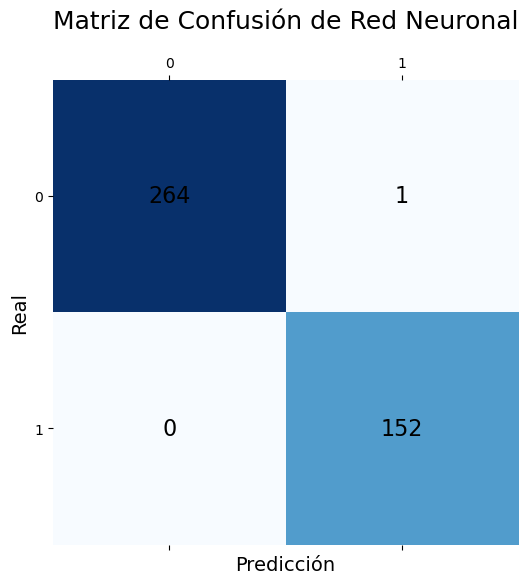

In [73]:
# Evaluar en el conjunto de validación
accuracy = best_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Accuracy en el conjunto de validación: {accuracy}")

# Generar predicciones en el conjunto de prueba
y_pred_probs = best_model.predict(X_test)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)  # Convertir probabilidades en predicciones binarias

precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.8f}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
# Graficar la matriz de confusión
# Graficar la matriz de confusión con matshow
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)  # Utilizar fignum=1 para evitar la creación de una nueva figura
plt.title('Matriz de Confusión de Red Neuronal', pad=20, fontsize=18)
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Real', fontsize=14)

# Agregar las anotaciones de los valores en la matriz
for (i, j), val in np.ndenumerate(conf_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', fontsize=16, color="black")

# Remover la barra de color
plt.gca().set_frame_on(False)  # Remueve el borde alrededor de la matriz

plt.show()


In [50]:
train[(train['Male'] == 1)&(train['Survived'] == 1)&(train['Pclass'] == 3)]

,PassengerId,Survived,Pclass,Age,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Alone,Large,Medium,Small,Female,Male
36,37,1,3,47.0,7.2292,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
64,66,1,3,19.0,15.2458,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
73,75,1,3,32.0,56.4958,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
80,82,1,3,29.0,9.5000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
106,108,1,3,47.0,7.7750,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
124,126,1,3,12.0,11.2417,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
126,128,1,3,24.0,7.1417,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
145,147,1,3,27.0,7.7958,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
164,166,1,3,9.0,20.5250,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
203,205,1,3,18.0,8.0500,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [34]:
train[(train['Female'] == 1)&(train['Survived'] == 1)]

,PassengerId,Survived,Pclass,Age,Fare,Group_Size,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Female,Male
1,2,1,1,38.0,71.2833,3,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.0,7.9250,0,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.0,53.1000,3,0.0,0.0,1.0,1.0,0.0
8,9,1,3,27.0,11.1333,3,0.0,0.0,1.0,1.0,0.0
9,10,1,2,14.0,30.0708,3,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
872,875,1,2,28.0,24.0000,3,1.0,0.0,0.0,1.0,0.0
873,876,1,3,15.0,7.2250,0,1.0,0.0,0.0,1.0,0.0
877,880,1,1,56.0,83.1583,3,1.0,0.0,0.0,1.0,0.0
878,881,1,2,25.0,26.0000,3,0.0,0.0,1.0,1.0,0.0
